# Addressing the Underfit Models II

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.model_selection import train_test_split
from music21 import *
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [21]:
path='/content/'


#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])


Loading Music File: /content/Piano Concerto n2 op19 1mov.mid
Loading Music File: /content/scn16_8.mid
Loading Music File: /content/midi207.mid
Loading Music File: /content/midi40.mid
Loading Music File: /content/Piano Sonata n22.mid
Loading Music File: /content/Symphony n7 3mov.mid
Loading Music File: /content/mendel_op30_5.mid
Loading Music File: /content/midi158.mid
Loading Music File: /content/Sketch for Piano Allegretto.mid
Loading Music File: /content/Waltz No.3.mid
Loading Music File: /content/Symphony n1 4mov.mid
Loading Music File: /content/Symphony n4 3mov.mid
Loading Music File: /content/Lieder op48 n3 ''Vom Tode''.mid
Loading Music File: /content/midi19.mid
Loading Music File: /content/midi263.mid
Loading Music File: /content/Piano Sonata n02.mid
Loading Music File: /content/Bwv0806 English Suite n1 01mov .mid
Loading Music File: /content/liz_et3.mid
Loading Music File: /content/midi20.mid
Loading Music File: /content/Revolutionary.mid
Loading Music File: /content/midi170.mi

In [22]:
#flatten array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

1231


In [23]:
print(len(notes_))

1461493


In [24]:
print("First fifty notes:",notes_[:50])

First fifty notes: ['F6', 'E6', 'F6', 'D6', 'B-5', 'F5', '9.0.3.5', 'F5', 'E5', 'F5', 'G5', 'A5', 'C6', 'B-5', '10.2.5', 'B-5', 'A5', 'B-5', 'C6', 'D6', 'F6', 'E-6', '5.9.0', 'E-6', 'E-6', 'F6', 'E-6', 'D6', 'E-6', 'F6', 'E-6', 'C#6', 'D6', '10.2.5', 'F5', 'E5', 'F5', 'G5', 'F5', 'E-5', 'D5', 'C5', 'B-4', 'A4', 'G4', 'F4', 'F4', 'E-3', 'F3', '5.9']


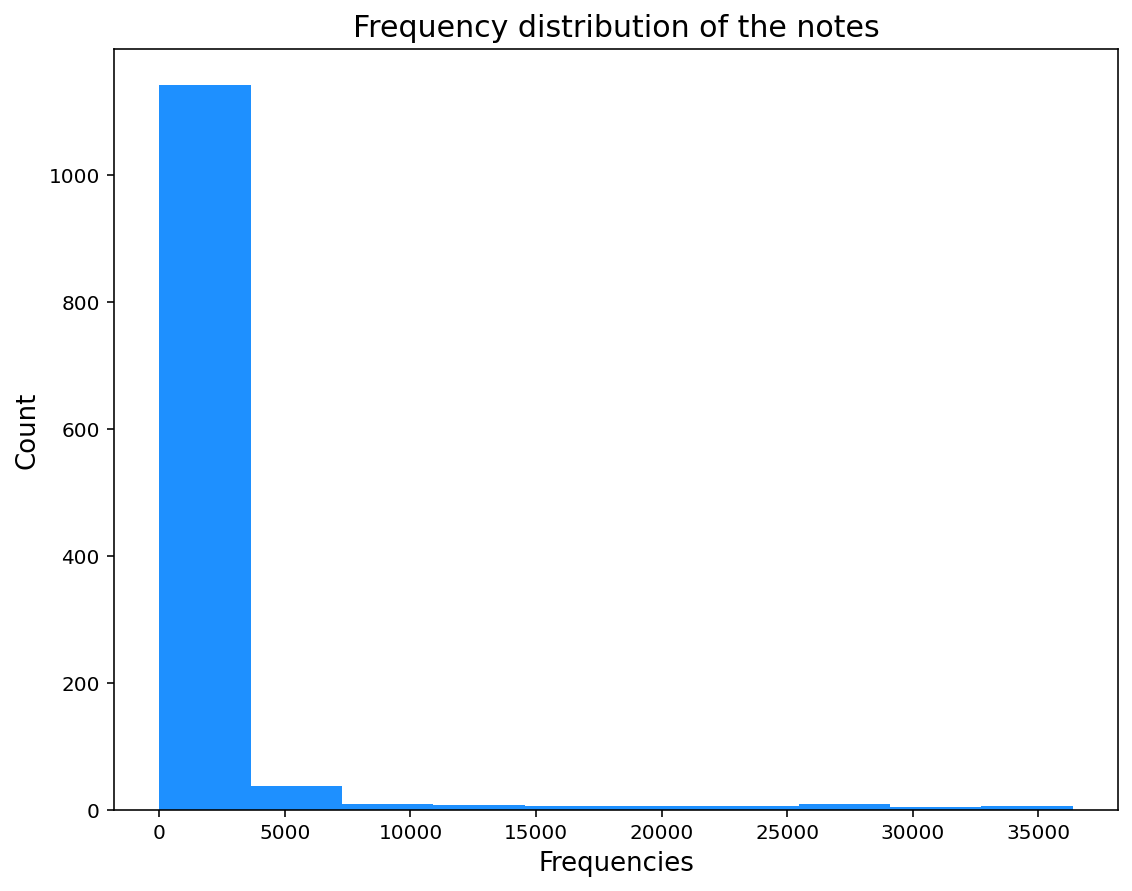

In [25]:
#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(9,7))

#plot
plt.title("Frequency distribution of the notes", fontsize=15)
plt.ylabel('Count', fontsize= 13)
plt.xlabel('Frequencies', fontsize= 13)
plt.hist(no, color = 'dodgerblue')
plt.savefig('/content/totaldistplot.png');

In [26]:
frequent_notes = [note_ for note_, count in freq.items() if count>=40]
#for this modeling frequent notes has been redefined to >40.  
#We had it initially defined as >50 in the first version of the model
print(len(frequent_notes))

367


In [27]:
#files will only contain frequent notes
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

In [28]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [29]:
#Each note gets a unique integer
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [30]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [31]:
#preparing integer sequences for output data.
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [32]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

## Make it compatible with lstm by reformatting input and output

In [33]:
n_vocab = len(set(notes))

In [34]:
len_unique=len(unique_notes)
len_unique

1231

In [35]:
len(y)

1431582

In [36]:
x_seq

array([[158, 168, 158, ..., 158, 362,  11],
       [168, 158, 203, ..., 362,  11, 203],
       [158, 203, 360, ...,  11, 203, 174],
       ...,
       [110, 115, 105, ..., 253, 113, 253],
       [115, 105, 154, ..., 113, 253,  35],
       [105, 154,  96, ..., 253,  35,  35]])

In [37]:
x_patterns=len(x)
x_input=(np.reshape(x_seq,(len(y),no_of_timesteps,1)))/len_unique
#https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

In [38]:
y=tf.keras.utils.to_categorical(y_seq)
#https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/

## LSTM Model

In [41]:
model14 = Sequential()
model14.add(LSTM(512, input_shape =(x_input.shape[1],x_input.shape[2]), return_sequences=True))
model14.add(Dropout(0.01))
model14.add(LSTM(512, return_sequences = False))
model14.add(Dropout(0.01))
model14.add(Dense(512, activation='relu'))
model14.add(Dropout(0.01))
model14.add(Dense(256, activation='relu'))
model14.add(Dropout(0.01))
model14.add(Dense(128, activation='relu'))
model14.add(Dropout(0.01))
model14.add(Dense(len(y), activation = 'softmax'))
model14.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr=.001))
model14.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32, 512)           1052672   
                                                                 
 dropout_5 (Dropout)         (None, 32, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)              

In [43]:
mc14=ModelCheckpoint('best_model_14.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

history14=model14.fit(np.array(x_tr), np.array(y_tr), batch_size=32, 
                    epochs=40, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc14])

Epoch 1/40
35789/35790 [============================>.] - ETA: 0s - loss: 4.5302
Epoch 00001: val_loss improved from inf to 4.45315, saving model to best_model_14.h5
35790/35790 [==============================] - 1060s 30ms/step - loss: 4.5302 - val_loss: 4.4531
Epoch 2/40
35789/35790 [============================>.] - ETA: 0s - loss: 4.4239
Epoch 00002: val_loss improved from 4.45315 to 4.36681, saving model to best_model_14.h5
35790/35790 [==============================] - 1056s 29ms/step - loss: 4.4239 - val_loss: 4.3668
Epoch 3/40
35789/35790 [============================>.] - ETA: 0s - loss: 4.3569
Epoch 00003: val_loss improved from 4.36681 to 4.31472, saving model to best_model_14.h5
35790/35790 [==============================] - 1058s 30ms/step - loss: 4.3569 - val_loss: 4.3147
Epoch 4/40
35789/35790 [============================>.] - ETA: 0s - loss: 4.2986
Epoch 00004: val_loss improved from 4.31472 to 4.26391, saving model to best_model_14.h5
35790/35790 [====================

In [65]:
from keras.models import load_model
model =load_model('best_model_14.h5')

In [73]:
import random
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions14 = []

for i in range(120):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model14.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions14.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions14)

[349, 349, 349, 349, 301, 156, 349, 301, 301, 156, 301, 301, 301, 156, 301, 301, 349, 156, 301, 301, 301, 156, 301, 301, 301, 156, 301, 156, 156, 156, 156, 156, 156, 156, 154, 154, 349, 160, 156, 156, 166, 166, 156, 156, 166, 166, 156, 156, 166, 156, 156, 166, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156, 156, 166, 156]


In [74]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))

predicted_notes14 = [x_int_to_note[i] for i in predictions14]

In [75]:
# convert preds to midi files
def convert_to_midi(prediction_output):

  offset = 0
  output_notes = []

  for pattern in prediction_output:

    if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
    else:    
      new_note = note.Note(pattern)
      new_note.offset = offset
      new_note.storedInstrument = instrument.Piano()
      output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
    offset += 1
  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp='music.mid')

In [76]:
convert_to_midi(predicted_notes14)

In [77]:
predicted_notes14

['C4',
 'C4',
 'C4',
 'C4',
 'A3',
 'F3',
 'C4',
 'A3',
 'A3',
 'F3',
 'A3',
 'A3',
 'A3',
 'F3',
 'A3',
 'A3',
 'C4',
 'F3',
 'A3',
 'A3',
 'A3',
 'F3',
 'A3',
 'A3',
 'A3',
 'F3',
 'A3',
 'F3',
 'F3',
 'F3',
 'F3',
 'F3',
 'F3',
 'F3',
 'B-3',
 'B-3',
 'C4',
 'G#3',
 'F3',
 'F3',
 'E4',
 'E4',
 'F3',
 'F3',
 'E4',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3',
 'F3',
 'E4',
 'F3']

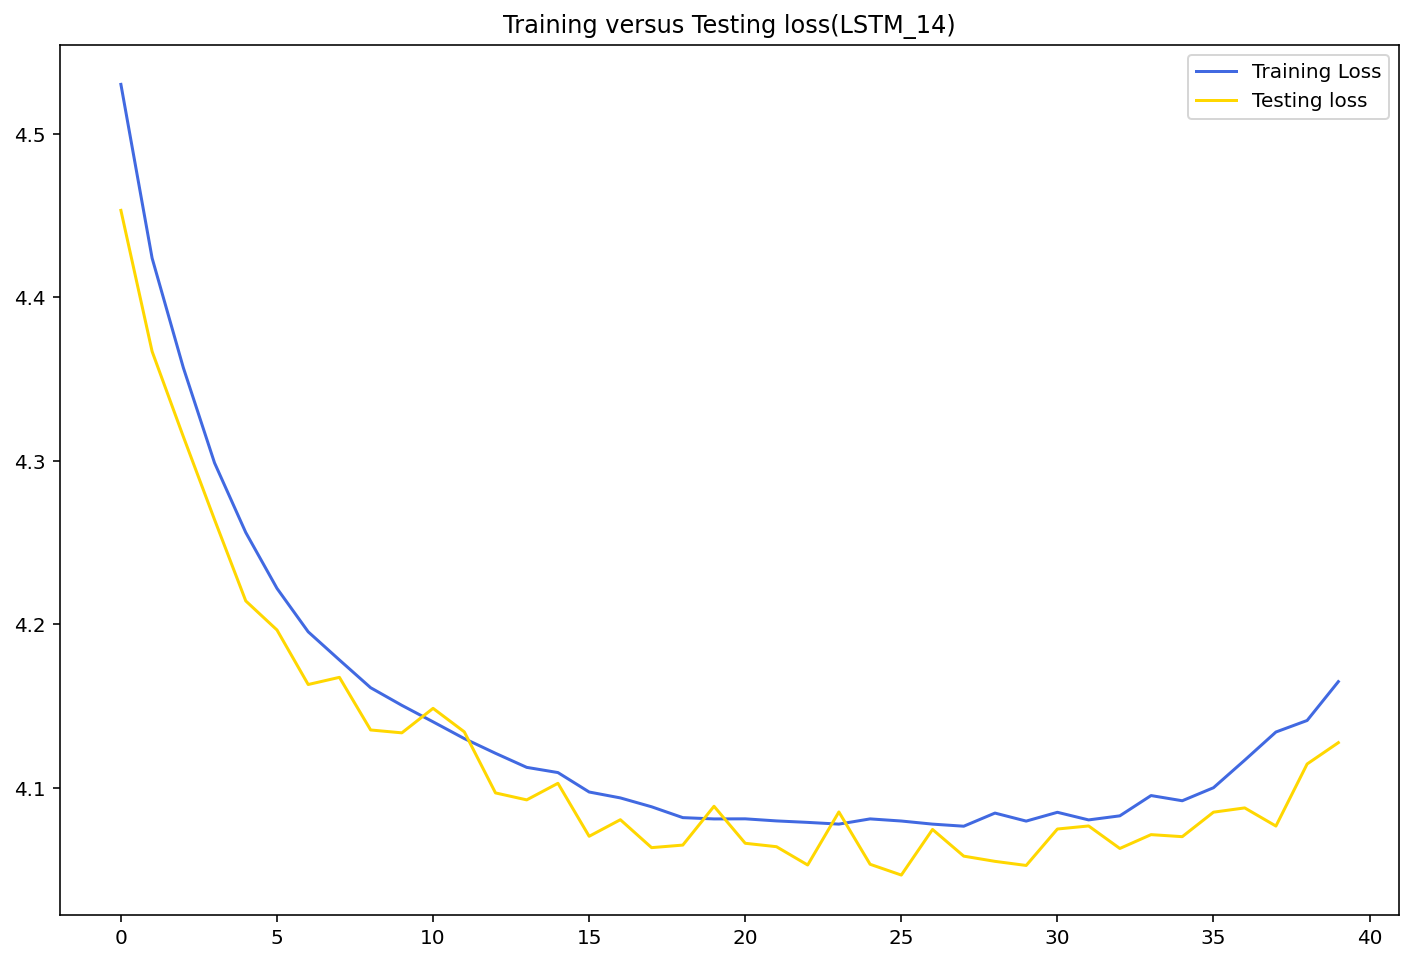

In [72]:
train_loss14=history14.history['loss']
test_loss14= history14.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(LSTM_14)')
plt.plot(train_loss14, label ='Training Loss', color = 'royalblue')
plt.plot(test_loss14, label = 'Testing loss', color = 'gold')
plt.legend();
plt.savefig('lstm_model_loss_plot(14).png')

This uses the architecture for model 11, in order to see if the model's success would scale with the added data.  While I was aiming to get the model to stop being under-fit, this new model is actually over fit.  The val_losses have also increased in baseline as more data gets added.  The Val loss here is 4.04647.

In [78]:
model15 = Sequential()

model15.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))
model15.add(Conv1D(512,3, padding= 'causal', dilation_rate=16, activation = 'relu'))
model15.add(Dropout(0.1))
model15.add(MaxPool1D(2))
model15.add(Conv1D(256,3, padding = 'causal', dilation_rate=8, activation = 'relu'))
model15.add(Dropout(0.15))
model15.add(MaxPool1D(2))
model15.add(Conv1D(128,3, activation= 'relu', dilation_rate=4, padding='causal'))
model15.add(Dropout(0.18))
model15.add(MaxPool1D(2))
model15.add(Conv1D(64,3, activation = 'relu', dilation_rate=2, padding= 'causal'))
model15.add(Dropout(0.2))
model15.add(MaxPool1D(2))
model15.add(GlobalMaxPool1D())

model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation= 'relu'))
model15.add(Dense(128, activation = 'relu'))
model15.add(Dense(len(unique_y), activation = 'softmax'))
model15.compile(loss = 'sparse_categorical_crossentropy', optimizer=Adam(lr=0.0007))
model15.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           36700     
                                                                 
 conv1d (Conv1D)             (None, 32, 512)           154112    
                                                                 
 dropout_10 (Dropout)        (None, 32, 512)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 256)           393472    
                                                                 
 dropout_11 (Dropout)        (None, 16, 256)           0         
                                                      

In [82]:
mc15=ModelCheckpoint('best_model_15.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

history15=model15.fit(np.array(x_tr), np.array(y_tr), batch_size=32, 
                    epochs=50, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc15])

Epoch 1/50
35789/35790 [============================>.] - ETA: 0s - loss: 3.9600
Epoch 00001: val_loss improved from inf to 3.91945, saving model to best_model_15.h5
35790/35790 [==============================] - 239s 7ms/step - loss: 3.9600 - val_loss: 3.9194
Epoch 2/50
35783/35790 [============================>.] - ETA: 0s - loss: 3.9152
Epoch 00002: val_loss improved from 3.91945 to 3.88487, saving model to best_model_15.h5
35790/35790 [==============================] - 237s 7ms/step - loss: 3.9152 - val_loss: 3.8849
Epoch 3/50
35784/35790 [============================>.] - ETA: 0s - loss: 3.8970
Epoch 00003: val_loss improved from 3.88487 to 3.87433, saving model to best_model_15.h5
35790/35790 [==============================] - 237s 7ms/step - loss: 3.8970 - val_loss: 3.8743
Epoch 4/50
35789/35790 [============================>.] - ETA: 0s - loss: 3.8865
Epoch 00004: val_loss improved from 3.87433 to 3.85623, saving model to best_model_15.h5
35790/35790 [==========================

In [183]:
model15 =load_model('best_model_15.h5')

In [184]:
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions15 = []

for i in range(150):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model15.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions15.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions15)

[191, 253, 191, 253, 191, 191, 191, 253, 191, 253, 253, 253, 253, 253, 158, 253, 158, 253, 253, 158, 253, 158, 158, 56, 56, 56, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154]


In [185]:
predicted_notes15 = [x_int_to_note[i] for i in predictions15]
convert_to_midi(predicted_notes15)
predicted_notes15

['C7',
 'B-6',
 'C7',
 'B-6',
 'C7',
 'C7',
 'C7',
 'B-6',
 'C7',
 'B-6',
 'B-6',
 'B-6',
 'B-6',
 'B-6',
 'F6',
 'B-6',
 'F6',
 'B-6',
 'B-6',
 'F6',
 'B-6',
 'F6',
 'F6',
 'C6',
 'C6',
 'C6',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3'

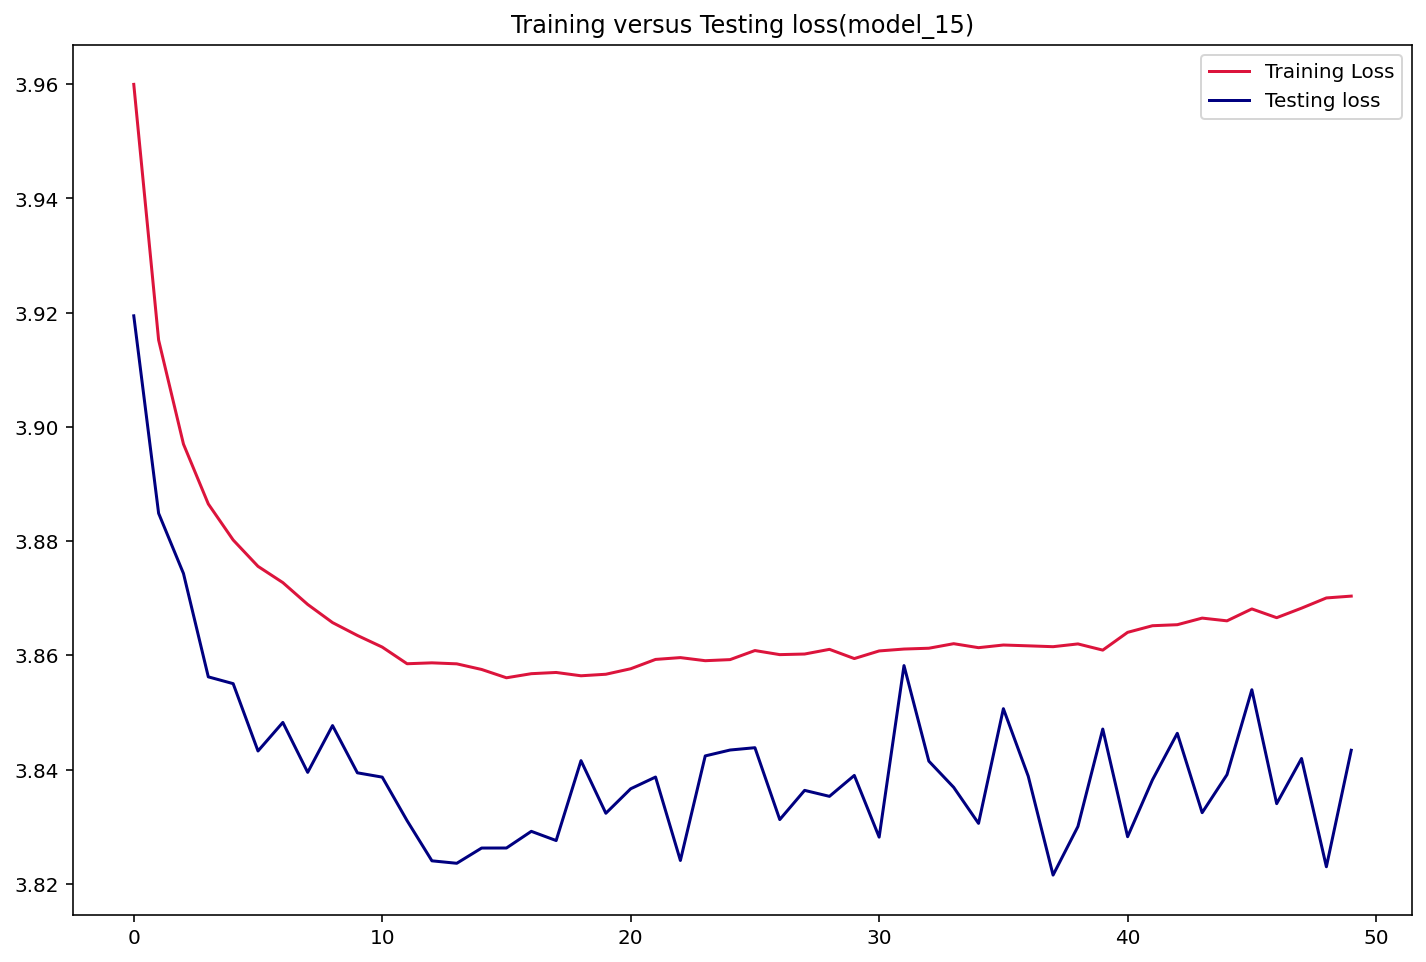

In [186]:
train_loss15=history15.history['loss']
test_loss15= history15.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(model_15)')
plt.plot(train_loss15, label ='Training Loss', color = 'crimson')
plt.plot(test_loss15, label = 'Testing loss', color = 'navy')
plt.legend();
plt.savefig('15th_Wave_loss_plot.png')

Same idea here, using similar architecture to model 5.  Once again the trend remains where all the additional data has now made the model very overfit.  This val loss is 3.8230 which is lower than the LSTM.  

In [187]:
model16 = Sequential()
#increase dropout layers to .25
model16.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))
model16.add(Conv1D(512,3, padding= 'causal', dilation_rate=16, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(MaxPool1D(2))
model16.add(Conv1D(256,3, padding = 'causal', dilation_rate=8, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(MaxPool1D(2))
model16.add(Conv1D(128,3, activation= 'relu', dilation_rate=4, padding='causal'))
model16.add(Dropout(0.25))
model16.add(MaxPool1D(2))
model16.add(Conv1D(64,3, activation = 'relu', dilation_rate=2, padding= 'causal'))
model16.add(Dropout(0.25))
model16.add(MaxPool1D(2))
model16.add(GlobalMaxPool1D())

model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation= 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(128, activation = 'relu'))
model16.add(Dense(len(unique_y), activation = 'softmax'))

model16.compile(loss = 'sparse_categorical_crossentropy', optimizer=Adam(lr=0.001))
#changed adam learning rate to .001
model16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 100)           36700     
                                                                 
 conv1d_4 (Conv1D)           (None, 32, 512)           154112    
                                                                 
 dropout_14 (Dropout)        (None, 32, 512)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 16, 512)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 256)           393472    
                                                                 
 dropout_15 (Dropout)        (None, 16, 256)           0         
                                                      

In [188]:
mc16=ModelCheckpoint('best_model_16.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

history16=model16.fit(np.array(x_tr), np.array(y_tr), batch_size=64, 
                    epochs=60, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc16])

Epoch 1/60
17895/17895 [==============================] - ETA: 0s - loss: 4.2150
Epoch 00001: val_loss improved from inf to 4.06107, saving model to best_model_16.h5
17895/17895 [==============================] - 139s 8ms/step - loss: 4.2150 - val_loss: 4.0611
Epoch 2/60
17891/17895 [============================>.] - ETA: 0s - loss: 4.0649
Epoch 00002: val_loss improved from 4.06107 to 4.00076, saving model to best_model_16.h5
17895/17895 [==============================] - 139s 8ms/step - loss: 4.0649 - val_loss: 4.0008
Epoch 3/60
17895/17895 [==============================] - ETA: 0s - loss: 4.0491
Epoch 00003: val_loss did not improve from 4.00076
17895/17895 [==============================] - 137s 8ms/step - loss: 4.0491 - val_loss: 4.0063
Epoch 4/60
17895/17895 [==============================] - ETA: 0s - loss: 4.0486
Epoch 00004: val_loss improved from 4.00076 to 3.99184, saving model to best_model_16.h5
17895/17895 [==============================] - 137s 8ms/step - loss: 4.0486 -

In [223]:
model16 =load_model('best_model_16.h5')

In [225]:
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions16 = []

for i in range(100):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model16.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions16.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions16)

[349, 128, 349, 128, 128, 128, 128, 128, 349, 349, 349, 39, 349, 349, 128, 39, 349, 128, 349, 128, 128, 349, 349, 128, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349]


In [226]:
predicted_notes16 = [x_int_to_note[i] for i in predictions16]

In [227]:
convert_to_midi(predicted_notes16)
predicted_notes16

['C4',
 'C5',
 'C4',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 'C4',
 'C4',
 'C4',
 'F5',
 'C4',
 'C4',
 'C5',
 'F5',
 'C4',
 'C5',
 'C4',
 'C5',
 'C5',
 'C4',
 'C4',
 'C5',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4',
 'C4']

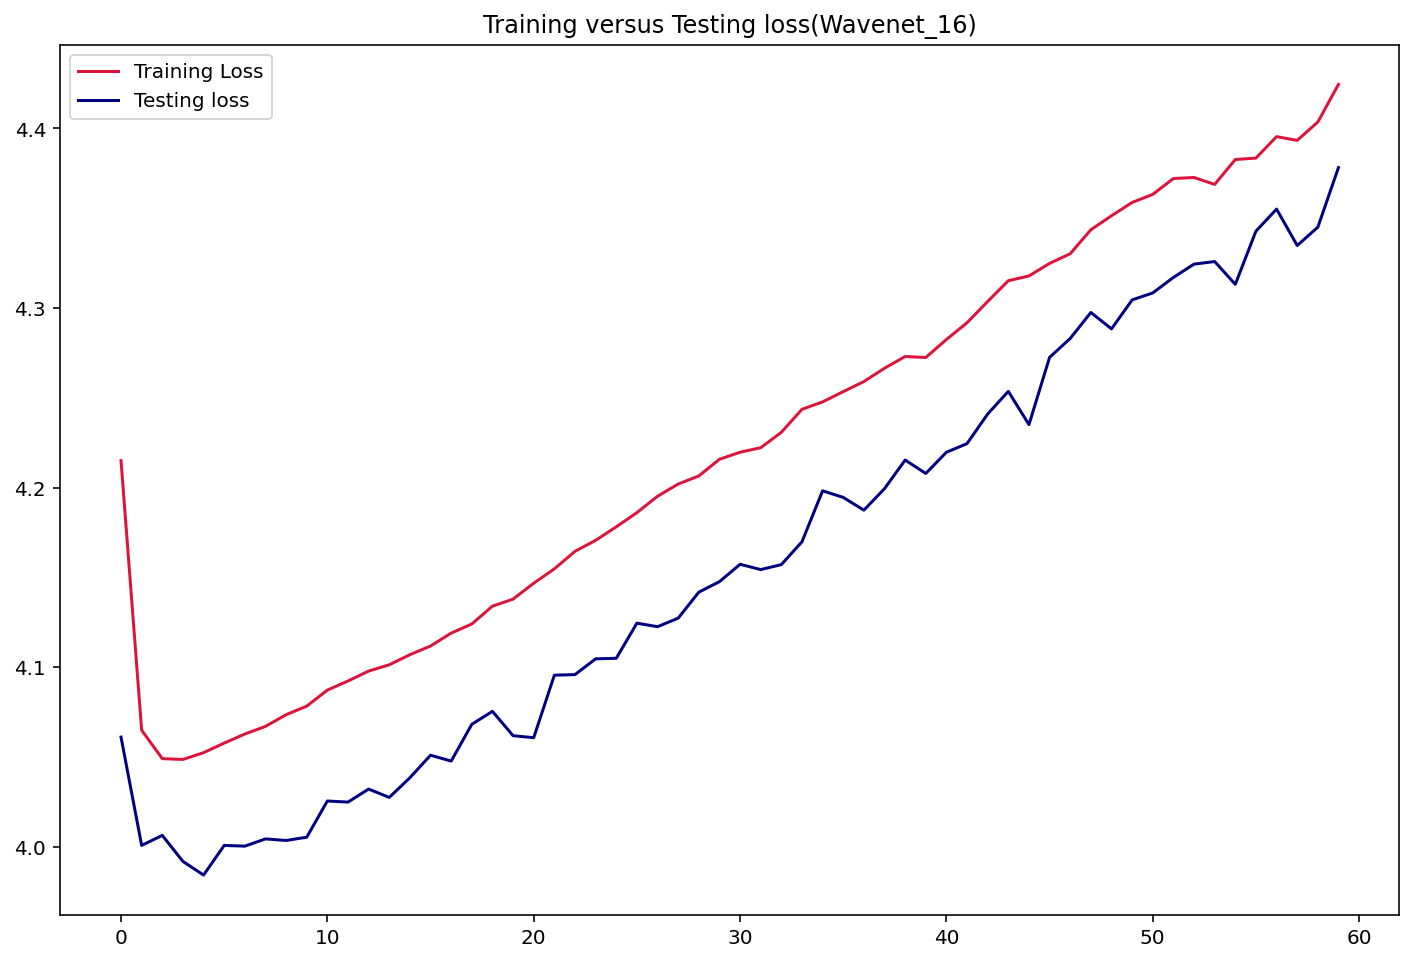

In [228]:
train_loss16=history16.history['loss']
test_loss16= history16.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(Wavenet_16)')
plt.plot(train_loss16, label ='Training Loss', color = 'crimson')
plt.plot(test_loss16, label = 'Testing loss', color = 'navy')
plt.legend();
plt.savefig('16thmodel_Wave_loss_plot.png')

Due to the overfitting I increased the dropout rate to .25 for each layer. However this model was still overfit and its val_loss kept increasing.  Research indicates that the learning rate could be too high, so a future iteration of this model would have to have a lower learning rate and a higher dropout rate.  


## Conclusions & Recommendations.

My methodology involved iterating through different wavenet and LSTM models in order to try and generate musical notes.  From this initial round of iterations the best performing models were the 4th Wavenet model as it has the lowest  val_loss at 3.20 followed by the 5th wavenet model at 3.21. If we are to select a good LSTM model from this round of iteration, then we can select the 6th LSTM model that had a val loss of 3.54461.  Interestingly these particular models also generated more dynamic notes and rhythms and show the potential of music generation.
From here we tried solving the under-fitting issue, although some under-fitting was fine as we did not want to simply reproduce the compositions.  We attempted an LSTM model with 1000 epochs, but that became overfit.  Also iterated through the aforementioned Wavenet and LSTM models that performed well in the first round.  Those were also overfit when introduced to more data. When hearing the compositions that these models come up with, there is a bit of a monotone quality to the composition.  At this moment in time you could not use these pieces as a basis or foundation for other works.
This is a mixed bag of performance, but when you hear some of the music generated you can see the potential that this has. 

The potential highlights:
* music4.midi
* music5.midi
* music6.midi
* music7.midi
* music8.midi
* music11.midi


### Next steps?

Would love access to more useable data.  Would need to clean up the midi files themselves as some of them have track layers with no data.  It would be a matter of removing the excess layers for these additional songs.  Tried some midi software but was unable to either save the subsequent file as midi or the software had no functionality to view these layers.  Additionally the LSTM model could potentially benefit from an encoder and decoder layer which could potentially improve performance of the model.  Or another approach could be combining a larger dataset with over 1000 epochs and an increased dropout.  That can be a fun part of iterating through these models, as they can be tinkered with endlessly. 

## References

### Music

*  http://davidtemperley.com/wp-content/uploads/2015/11/temperley-mp99.pdf
* http://extras.humdrum.org/man/keycor/
* https://en.wikipedia.org/wiki/Musical_note
* https://web.mit.edu/music21/doc/about/what.html
* http://musicandcomputersbook.com/
* https://www.britannica.com/art/music

### Neural networks

* https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/#h2_1

* https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/

* https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other

* https://stackoverflow.com/questions/63073760/using-dilated-convolution-in-keras

* https://stackoverflow.com/questions/47299624/how-to-understand-loss-acc-val-loss-val-acc-in-keras-model-fitting/47303461

* https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

* https://web.mit.edu/music21/doc/index.html


* https://towardsdatascience.com/pyzzicato-piano-instrumental-music-generation-using-deep-neural-networks-ed9e89320bf6